# Semantic Segmentation (2D)


This exercise will demonstrate a very simple approach to perform *semantic segmentation* with convolutional neural networks. *Semantic segmentation* means, we aim to assign every pixel of the input image one of several different classes (background, cell interior, cell boundary) without distinguishing objects of the same class.

![](_images/task_semantic.png)

## Setup and imports

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from pathlib import Path
import skimage
from skimage.segmentation import find_boundaries
import tensorflow as tf


from csbdeep.internals.nets import common_unet, custom_unet
from csbdeep.internals.blocks import unet_block, resnet_block

Init Plugin
Init Graph Optimizer
Init Kernel


## Data


First we download some sample images and corresponding masks

In [2]:
from csbdeep.utils import download_and_extract_zip_file, normalize

download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


Next we load the data, generate from the annotation masks background/foreground/cell border masks, and crop out a central patch (this is just for simplicity, as it makes our life a bit easier when all images have the same shape)

In [5]:

def crop(u,shape=(256,256)):
    """Crop central region of given shape"""
    return u[tuple(slice((s-m)//2,(s-m)//2+m) for s,m in zip(u.shape,shape))]

def to_3class_label(lbl, onehot=True):
    """Convert instance labeling to background/inner/outer mask"""
    b = find_boundaries(lbl,mode='outer')
    res = (lbl>0).astype(np.uint8)
    res[b] = 2
    if onehot:
        res = tf.keras.utils.to_categorical(res,num_classes=3).reshape(lbl.shape+(3,))
    return res

# load and crop out central patch (for simplicity)
X       = [normalize(crop(imread(x))) for x in sorted(glob('data/dsb2018/train/images/*.tif'))]
Y_label = [to_3class_label(crop(imread(y))) for y in sorted(glob('data/dsb2018/train/masks/*.tif'))]

# convert to numpy arrays
X, Y = np.expand_dims(np.stack(X),-1), np.stack(Y)

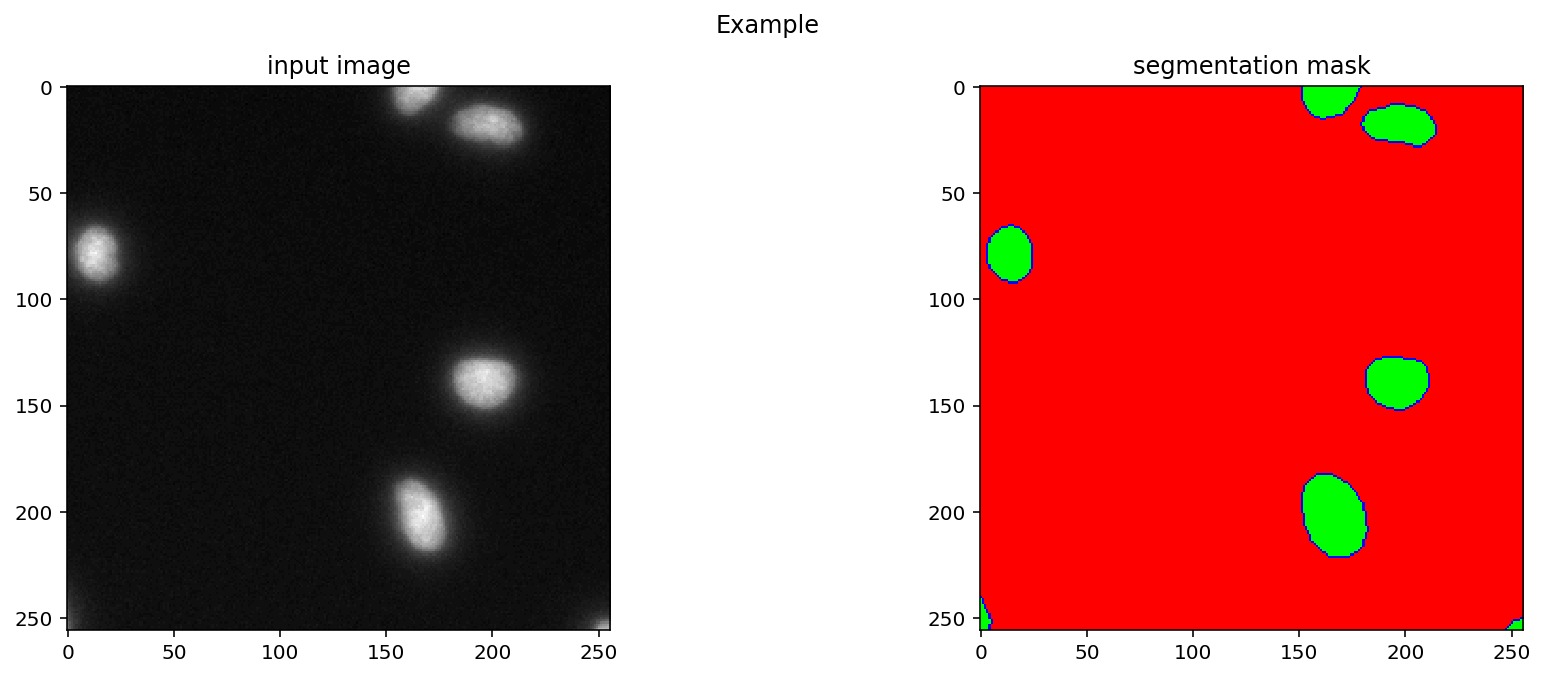

In [29]:
# plot an example image
idx = 3
fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
a0.imshow(X[i,...,0],cmap='gray');  
a0.set_title('input image')
a1.imshow(Y[i]);                    
a1.set_title('segmentation mask')
fig.suptitle("Example")
None;

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

1)  Plot some more images. What kind of data is shown? How variable is it? Do the segmentation masks look reasonable? 
        
</div>


We now split the training data into ~ 80/20 training and validation data

In [32]:
from csbdeep.data import shuffle_inplace

# shuffle data
shuffle_inplace(X, Y, seed=0)

# split into 80% training and 20% validation images
n_val = len(X) // 5
def split_train_val(a):
    return a[:-n_val], a[-n_val:]
X_train,       X_val       = split_train_val(X)
Y_train,       Y_val       = split_train_val(Y)

print(f'training   data: {len(X_train)} images and {len(Y_train)} masks')
print(f'validation data: {len(X_val)} images and {len(Y_val)} masks')

training   data: 358 images and 358 masks
validation data: 89 images and 89 masks


## Building a UNet 

We now will construct a very simple 3-class segmentation model, for which we will use a UNet

<img width=400 src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"></img>

For the actual implementation, we will make use of the function `custom_unet` from `csbdeep.internals.nets`

In [34]:
from csbdeep.internals.nets import custom_unet

In [35]:
model = custom_unet(input_shape=(None,None,1), n_channel_out=3, kernel_size=(3,3), pool_size=(2,2), 
                    n_filter_base=32, last_activation='softmax')

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 9248        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
____________________________________________________________________________________________

<div class="alert alert-block alert-info"><h2>Exercise</h2> 
    

Apply the (untrained) model on a example image (with `model.predict`). What is the output? How is it normalized?
        
</div>

### Compiling the model 

We now will compile the model, i.e. deciding on a loss function and a optimizer.

As we have a classification task with multiple output classes, we will use a simple `categorical_crossentropy` loss as loss function. Furthermore, `Adam` with the a learning rate on the order of `1e-4 - 1e-3` is a safe default (General reading tip: http://karpathy.github.io/2019/04/25/recipe/ :)

In [36]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))

Before we train the model, we define some callbacks that will monitor the training loss etc

In [40]:
from csbdeep.utils.tf import CARETensorBoardImage

logdir = Path('models/1_semantic_segmentation_2D')
logdir.mkdir(parents=True, exist_ok=True)
callbacks = []
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=logdir))
callbacks.append(CARETensorBoardImage(model=model, data=(X_val,Y_val),
                            log_dir=logdir/'images',
                            n_images=3))


2021-11-24 01:21:40.743960: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-24 01:21:40.743977: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-24 01:21:40.744044: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Ready to train!

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_val,Y_val),
                            epochs=100, callbacks=callbacks, verbose=1)

2021-11-24 01:22:42.936275: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 01:22:42.940214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-11-24 01:22:43.188214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 48s - loss: 1.1031

2021-11-24 01:22:47.378902: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-24 01:22:47.378920: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/12 [====>.........................] - ETA: 23s - loss: 1.1000

2021-11-24 01:22:49.670058: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-24 01:22:49.681820: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-24 01:22:49.699126: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: models/1_semantic_segmentation_2D/train/plugins/profile/2021_11_24_01_22_49

2021-11-24 01:22:49.700695: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to models/1_semantic_segmentation_2D/train/plugins/profile/2021_11_24_01_22_49/mac13.trace.json.gz
2021-11-24 01:22:49.707618: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: models/1_semantic_segmentation_2D/train/plugins/profile/2021_11_24_01_22_49

2021-11-24 01:22:49.707924: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to models/1_semantic_segmentation_2

12/12 [==============================] - ETA: 0s - loss: 1.0599

2021-11-24 01:23:06.642519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 26s 2s/step - loss: 1.0599 - val_loss: 0.9127


2021-11-24 01:23:08.981642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
10/12 [========================>.....] - ETA: 3s - loss: 0.6261

### Predict

In [ ]:
# can predict via keras model, but only works for properly-shaped and normalized images
Yhat_val = model.keras_model.predict(X_val, batch_size=8)
Yhat_val.shape

In [ ]:
i = 1
img, lbl, mask = X_val[i,:223,:223,0], Y_label_val[i,:223,:223], Y_val[i,:223,:223]
img.shape, lbl.shape, mask.shape

In [ ]:
# U-Net models expects input to be divisible by certain sizes, hence fails here.
try:
    model.keras_model.predict(img[np.newaxis])
except ValueError as e:
    print(e)

In [ ]:
mask_pred = model.predict(img, axes='YX')
mask_pred.shape

In [ ]:
from skimage.measure import label

# threshold inner (green) and find connected components
lbl_pred = label(mask_pred[...,1] > 0.7)

fig, ((a0,a1,a2),(b0,b1,b2)) = plt.subplots(2,3,figsize=(15,10))
a0.imshow(img,cmap='gray');       a0.set_title('input image')
a1.imshow(lbl,cmap='tab20');      a1.set_title('label image')
a2.imshow(mask);                  a2.set_title('segmentation mask')
b0.axis('off')
b1.imshow(lbl_pred,cmap='tab20'); b1.set_title('label image (prediction)')
b2.imshow(mask_pred);             b2.set_title('segmentation mask (prediction)')
fig.suptitle("Example")
None;

## Tile iterator to process large images

In [ ]:
from csbdeep.internals.predict import tile_iterator
help(tile_iterator)

In [ ]:
img = imread('data/dsb2018/test/images/5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed.tif')
img = normalize(img, 1,99.8)
plt.figure(figsize=(8,8))
plt.imshow(img, clim=(0,1), cmap='gray')
plt.title(f"example image with shape = {img.shape}");

In [ ]:
import matplotlib.patches as patches

def process(x):
    return model.predict(x, axes='YX')

img_processed       = process(img)
img_processed_tiled = np.empty_like(img_processed)

###

block_sizes = (8,8)
n_block_overlaps = (3,5)
n_tiles = (3,5)

print(f"block_sizes = {block_sizes}")
print(f"n_block_overlaps = {n_block_overlaps}")
print(f"n_tiles = {n_tiles}")

fig, ax = plt.subplots(*n_tiles, figsize=(15,8))
ax = ax.ravel()
[a.axis('off') for a in ax]
i = 0

for tile,s_src,s_dst in tile_iterator(img, n_tiles, block_sizes, n_block_overlaps, guarantee='size'):
    # tile is padded; will always start and end at a multiple of block size
    # tile[s_src] removes the padding (shown in magenta)
    # the slice s_dst denotes the region where tile[s_src] comes from
    
    # process tile, crop the padded region from the result and put it at its original location
    img_processed_tiled[s_dst] = process(tile)[s_src]
            
    ax[i].imshow(tile, clim=(0,1), cmap='gray')
    rect = patches.Rectangle( [s.start        for s in reversed(s_src)],
                             *[s.stop-s.start for s in reversed(s_src)],
                              edgecolor='none',facecolor='m',alpha=0.6)
    ax[i].add_patch(rect)    
    i+=1

plt.tight_layout()

assert np.allclose(img_processed, img_processed_tiled)
None;